<div class="alert alert-info"> <h1> Spam / Ham Detection using XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import string
import re
from sympy.abc import alpha
import xgboost as xgb
from xgboost import XGBClassifier
from wordcloud import WordCloud
from collections import Counter
import nltk
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
d = pd.read_csv('fraud_detect.csv')
data = d.copy()
df = pd.DataFrame(data)

df = df.drop(df[df['Category'] == '{"mode":"full"'].index, axis=0)
df = df.drop_duplicates(subset=['Message'])



<div class="alert alert-info"> <h2> Clean Text Data:</h2>
<p> Clean text data by removing stopwords, lemmatizing, unnecessary characters, punctuation and tokenize the sentences

In [3]:
def clean_text(text):

    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    # remove links, url, www etc
    text = re.sub(r"http\S+|www\S+", "", text)
    # remove email etc
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "", text)


    text = text.lower()
    return text

In [4]:
df['Message'] = df['Message'].apply(clean_text)
df['Category_Number'] = df['Category'].map({'ham': 0, 'spam': 1})
df.head()

,Message,Category,Category_Number
0,oh really perform write a paper go to a movie ...,ham,0
1,a seller we would want to inform guests that b...,spam,1
2,u were outbid by simonwatson5120 on the shinco...,spam,1
3,k then 2marrow are you coming to class,ham,0
4,can you let me know details of fri when u find...,ham,0


<div class="alert alert-info"> <h2> Begin Exploratory Data Analysis</h2>
<h3> WordCloud

In [5]:
colors = sns.color_palette("Set2", 4)
colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

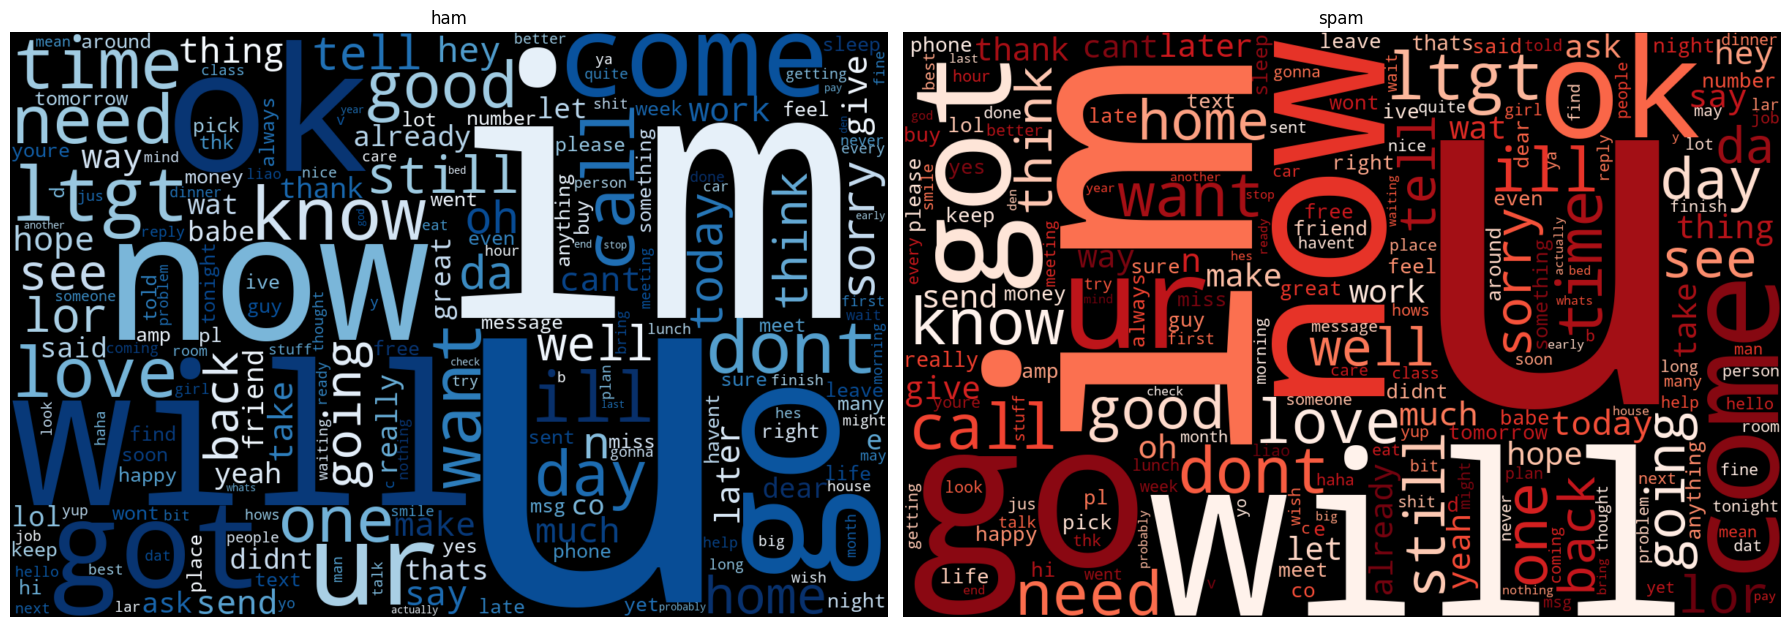

In [6]:
ham_messages = df[df['Category'] == 'ham']['Message']
spam_messages = df[df['Category'] == 'spam']['Message']

ham_text = ' '.join(ham_messages)
spam_text = ' '.join(spam_messages)

ham_wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='black',
    max_words=200,
    colormap='Blues'

).generate(ham_text)

spam_wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='black',
    max_words=200,
    colormap='Reds'

).generate(ham_text)


plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('ham')
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('spam')
plt.axis('off')

plt.tight_layout()
plt.show()

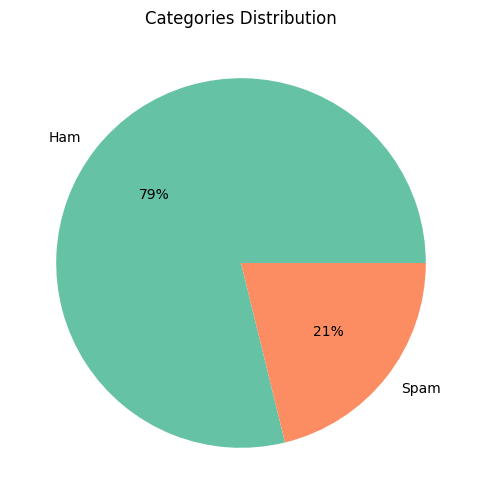

In [7]:
category_counts = df['Category'].value_counts()

plt.figure(figsize=(8, 6))
colors = sns.color_palette("Set2", 2)
plt.pie(category_counts, labels=['Ham', 'Spam'], colors=colors, autopct='%1.0f%%')
plt.title('Categories Distribution')
plt.show()

<div class="alert alert-info"> <h2> Analyze the Message Length and add col to the DataFrame

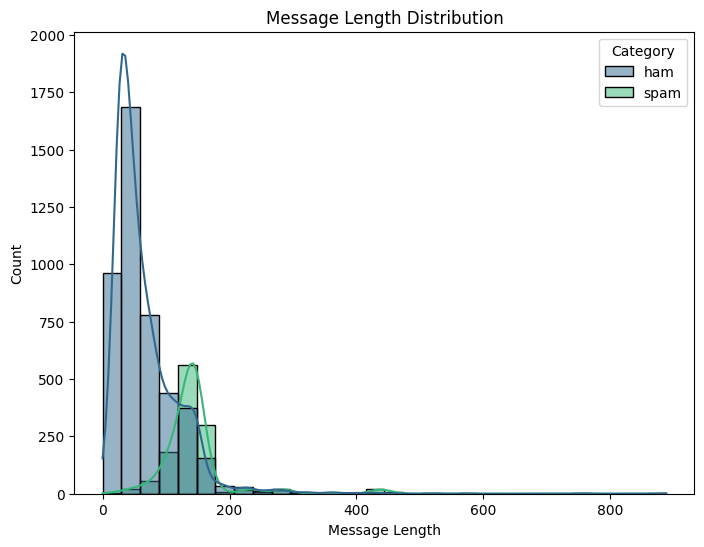

In [8]:
df['Message_Length'] = df['Message'].str.len()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Message_Length', hue='Category', kde=True, palette='viridis', bins=30)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.grid(False)
plt.show()

<div class="alert alert-info"> <h3> <i> Result:</i><br>Messages contain < 200 characters</h3>
<h2> Analyze Most Frequent Words: <b>Unigrams, Bigrams, Trigrams</b></h2>
<p> Erklärung: Sie helfen bei der Erstellung von Modellen, die die Wahrscheinlichkeit von Wortfolgen in einem Text abschätzen.
Beispiel: In einem Bigram-Modell könnte die Wahrscheinlichkeit von "ist ein" berechnet werden, basierend darauf, wie oft diese Kombination in einem Trainingsdatensatz vorkommt.

In [9]:
def get_unigrams(category):
    words = ''.join(df[df['Category'] == category]['Message'])
    word_tokens = nltk.word_tokenize(words.lower())
    word_counts = Counter(word_tokens)
    most_common_words = word_counts.most_common(20)

    words, counts = zip(*most_common_words)


def get_bigrams(category):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    ngrams = vectorizer.fit_transform(df[df['Category'] == category]['Message']).toarray()
    sum_ngrams = ngrams.sum(axis=0).flatten()

    bigram_freq = dict(zip(vectorizer.get_feature_names_out(), sum_ngrams))
    sorted_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

    bigrams, freqs = zip(*sorted_bigrams[:20])


def get_trigrams(category):
    vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
    ngrams = vectorizer.fit_transform(df[df['Category'] == category]['Message']).toarray()
    sum_ngrams = ngrams.sum(axis=0).flatten()
    trigram_freq = dict(zip(vectorizer.get_feature_names_out(), sum_ngrams))
    sorted_trigrams = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

    trigrams, freqs = zip(*sorted_trigrams[:20])


<div class="alert alert-info"> <h2> Prepare Dataset for Model training

In [10]:
X = df['Message']
y = df['Category_Number']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

<div class="alert alert-success"> <h2> Find optimal Model Parameters:

In [11]:
best_params = {'n_estimators': 467,
 'max_depth': 4,
 'learning_rate': 0.14014899942971895,
 'subsample': 0.9968781941622266,
 'colsample_bytree': 0.6812355146666758,
 'gamma': 0.46844534449232467,
 'min_child_weight': 1}

In [12]:
model = XGBClassifier(**best_params)
model.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6812355146666758, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.46844534449232467,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14014899942971895,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=467, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
class_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 0.962478184991274
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       915
        spam       0.97      0.84      0.90       231

    accuracy                           0.96      1146
   macro avg       0.96      0.92      0.94      1146
weighted avg       0.96      0.96      0.96      1146



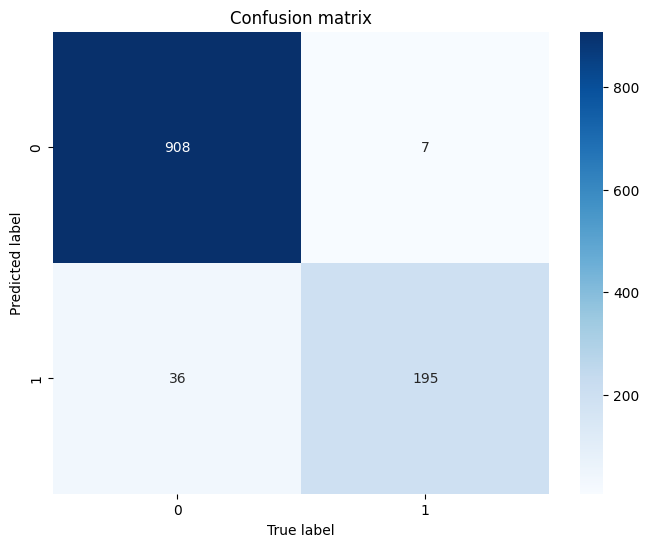

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

<div class="alert alert-info"> <h2> Test Model

In [15]:
new = "Congratulations! You've won a free iPhone 15! To claim your prize, just follow this link and fill out the form: [link]. Don't miss out, offer ends soon!"


def spam_check(text):
    tfidf = vectorizer.transform([text])
    predictions = model.predict(tfidf)
    confidences = model.predict_proba(tfidf)
    label_mapping = {1: 'SPAM', 0: 'HAM'}
    result = predictions[0]
    confidence = np.round(confidences[0][result] * 100, 4)
    return label_mapping[result], confidence



res, conf = spam_check(new)
print(res, conf)

SPAM 99.9999
